In [26]:
# Check jupyter or not
from IPython import get_ipython
def type_of_script():
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str: return 'jupyter'
        if 'terminal' in ipy_str: return 'ipython'
    except: return 'terminal'
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm

# Default libraries
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects
from matplotlib import colormaps
from matplotlib.colors import Normalize
import cmasher as cmr
import numpy as np
import os, glob, atexit, signal, time, warnings
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# rur package
from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0

# Custom package
from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from common_func import *
from ramses_function import *

# Python Argument Parser
# print("ex: $ python3 06c_stable_tree.py [--mod 7]")
# import argparse
# parser = argparse.ArgumentParser(description='(syj3514@yonsei.ac.kr)')
# parser.add_argument("-m", "--mod", required=True, help='mod', type=int)
# args = parser.parse_args()
# mod = args.mod

In [27]:
ncpu=48
home = '/home/jeon'
if(not os.path.isdir(home)): home = '/gem_home/jeon'

In [28]:
mode1 = 'nh'; database1 = f"{home}/MissingSat/database/{mode1}"
iout1 = 1026; repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1); snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
# gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
# hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1, allsubs1, states1, dinks1, pairs1, upairs1 = extract_from_LG(LG1)
print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [29]:
mode2 = 'nh2'; database2 = f"{home}/MissingSat/database/{mode2}"
iout2 = 797; repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2); snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
# gals1 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
# hals1 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2, allsubs2, states2, dinks2, pairs2, upairs2 = extract_from_LG(LG2)
print(len(allsubs2), np.unique(states2, return_counts=True))  

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [30]:
stree1 = pklload(f"{database1}/stable_tree_new.pickle")
rtree1 = pklload(f"{database1}/stable_tree_raw.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)
stree2 = pklload(f"{database2}/stable_tree_new.pickle")
rtree2 = pklload(f"{database2}/stable_tree_raw.pickle")

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [31]:
casedict = {'NH':{'d':None, 'p':None, 'u':None}, 'NH2':{'d':None, 'p':None, 'u':None}}

# Case by Case

## Dink

### NH1

no star forever 141 12.31%
had stars, but not now 574 50.13%
has stars 430 37.55%
no SF forever 1019 89.00%
had SF, but not now 126 11.00%
has SF 0 0.00%
No star
    No SF 141
    had SF 0
    has SF 0
Had star
    No SF 549
    had SF 25
    has SF 0
Has star
    No SF 329
    had SF 101
    has SF 0


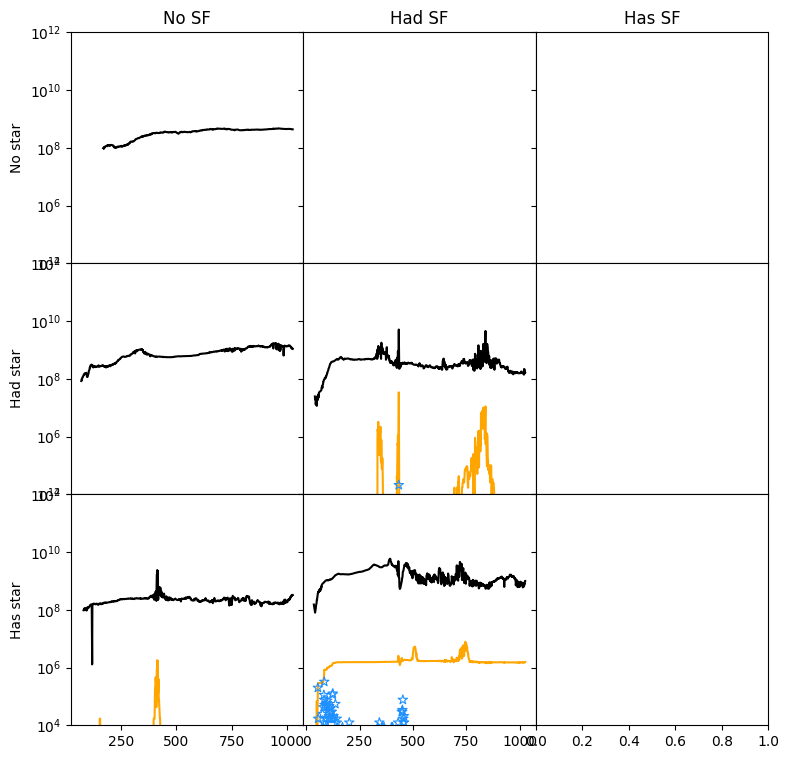

In [32]:
d1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for dink in dinks1:
    branch = stree1[dink['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d1cases[0][1].append(dink['id'])
    else:
        if(dink['mstar_vir']==0):
            d1cases[1][1].append(dink['id'])
        else:
            d1cases[2][1].append(dink['id'])
for case in d1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(dinks1)*100:.2f}%")

d2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for dink in dinks1:
    branch = stree1[dink['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d2cases[0][1].append(dink['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            d2cases[1][1].append(dink['id'])
        else:
            d2cases[2][1].append(dink['id'])
for case in d2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(dinks1)*100:.2f}%")

d1a = d1cases[0][1]; d1b = d1cases[1][1]; d1c = d1cases[2][1]
d2a = d2cases[0][1]; d2b = d2cases[1][1]; d2c = d2cases[2][1]
dcases = []
print('No star')
ids = np.array(d1a)[isin(d1a,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['No star',"No SF", ids])
ids = np.array(d1a)[isin(d1a,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['No star',"Had SF", ids])
ids = np.array(d1a)[isin(d1a,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(d1b)[isin(d1b,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Had star',"No SF", ids])
ids = np.array(d1b)[isin(d1b,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Had star',"Had SF", ids])
ids = np.array(d1b)[isin(d1b,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(d1c)[isin(d1c,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Has star',"No SF", ids])
ids = np.array(d1c)[isin(d1c,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Has star',"Had SF", ids])
ids = np.array(d1c)[isin(d1c,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Has star',"Has SF", ids])
casedict['NH']['d'] = dcases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(dcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.8)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)

### NH2

no star forever 204 18.21%
had stars, but not now 537 47.95%
has stars 379 33.84%
no SF forever 971 86.70%
had SF, but not now 147 13.12%
has SF 2 0.18%
No star
    No SF 204
    had SF 0
    has SF 0
Had star
    No SF 505
    had SF 32
    has SF 0
Has star
    No SF 262
    had SF 115
    has SF 2


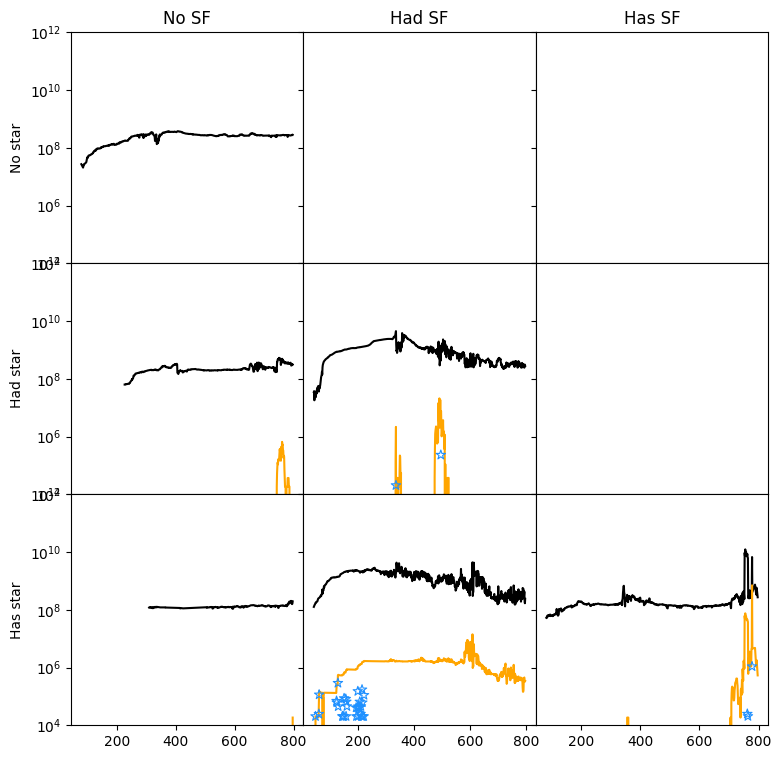

In [33]:
d1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for dink in dinks2:
    branch = stree2[dink['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d1cases[0][1].append(dink['id'])
    else:
        if(dink['mstar_vir']==0):
            d1cases[1][1].append(dink['id'])
        else:
            d1cases[2][1].append(dink['id'])
for case in d1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(dinks2)*100:.2f}%")

d2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for dink in dinks2:
    branch = stree2[dink['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d2cases[0][1].append(dink['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            d2cases[1][1].append(dink['id'])
        else:
            d2cases[2][1].append(dink['id'])
for case in d2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(dinks2)*100:.2f}%")

d1a = d1cases[0][1]; d1b = d1cases[1][1]; d1c = d1cases[2][1]
d2a = d2cases[0][1]; d2b = d2cases[1][1]; d2c = d2cases[2][1]
dcases = []
print('No star')
ids = np.array(d1a)[isin(d1a,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['No star',"No SF", ids])
ids = np.array(d1a)[isin(d1a,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['No star',"Had SF", ids])
ids = np.array(d1a)[isin(d1a,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(d1b)[isin(d1b,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Had star',"No SF", ids])
ids = np.array(d1b)[isin(d1b,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Had star',"Had SF", ids])
ids = np.array(d1b)[isin(d1b,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(d1c)[isin(d1c,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Has star',"No SF", ids])
ids = np.array(d1c)[isin(d1c,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Has star',"Had SF", ids])
ids = np.array(d1c)[isin(d1c,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Has star',"Has SF", ids])
casedict['NH2']['d'] = dcases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(dcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree2[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.8)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)

### How to do?
- (No star No SF): Normal: **just full movie**
- (Had star No SF): Whether interloper / stripping : **see star having period**
- (Has star No SF): Whether interloper / merging : **see star having period**

- (Had star Had SF): Whether interloper / stripping : **see star having period and SF epoch**
- (Has star Had SF): Whether interloper / stripping / merging : **see star having period and SF epoch**

## Pair

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 130 100.00%
no SF forever 5 3.85%
had SF, but not now 89 68.46%
has SF 36 27.69%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 5
    had SF 89
    has SF 36


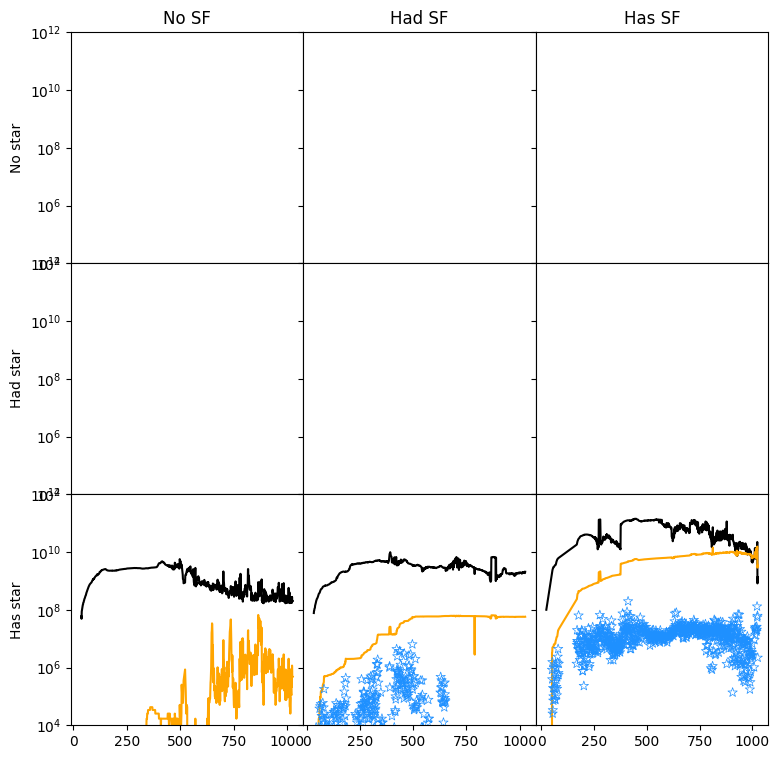

In [34]:
p1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for pair in pairs1:
    branch = stree1[pair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p1cases[0][1].append(pair['id'])
    else:
        if(pair['mstar_vir']==0):
            p1cases[1][1].append(pair['id'])
        else:
            p1cases[2][1].append(pair['id'])
for case in p1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(pairs1)*100:.2f}%")

p2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for pair in pairs1:
    branch = stree1[pair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p2cases[0][1].append(pair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            p2cases[1][1].append(pair['id'])
        else:
            p2cases[2][1].append(pair['id'])
for case in p2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(pairs1)*100:.2f}%")

p1a = p1cases[0][1]; p1b = p1cases[1][1]; p1c = p1cases[2][1]
p2a = p2cases[0][1]; p2b = p2cases[1][1]; p2c = p2cases[2][1]
pcases = []
print('No star')
ids = np.array(p1a)[isin(p1a,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['No star',"No SF", ids])
ids = np.array(p1a)[isin(p1a,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['No star',"Had SF", ids])
ids = np.array(p1a)[isin(p1a,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(p1b)[isin(p1b,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['Had star',"No SF", ids])
ids = np.array(p1b)[isin(p1b,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['Had star',"Had SF", ids])
ids = np.array(p1b)[isin(p1b,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(p1c)[isin(p1c,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['Has star',"No SF", ids])
ids = np.array(p1c)[isin(p1c,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['Has star',"Had SF", ids])
ids = np.array(p1c)[isin(p1c,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['Has star',"Has SF", ids])
casedict['NH']['p'] = pcases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(pcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.5)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show(); plt.close()

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 79 100.00%
no SF forever 0 0.00%
had SF, but not now 48 60.76%
has SF 31 39.24%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 0
    had SF 48
    has SF 31


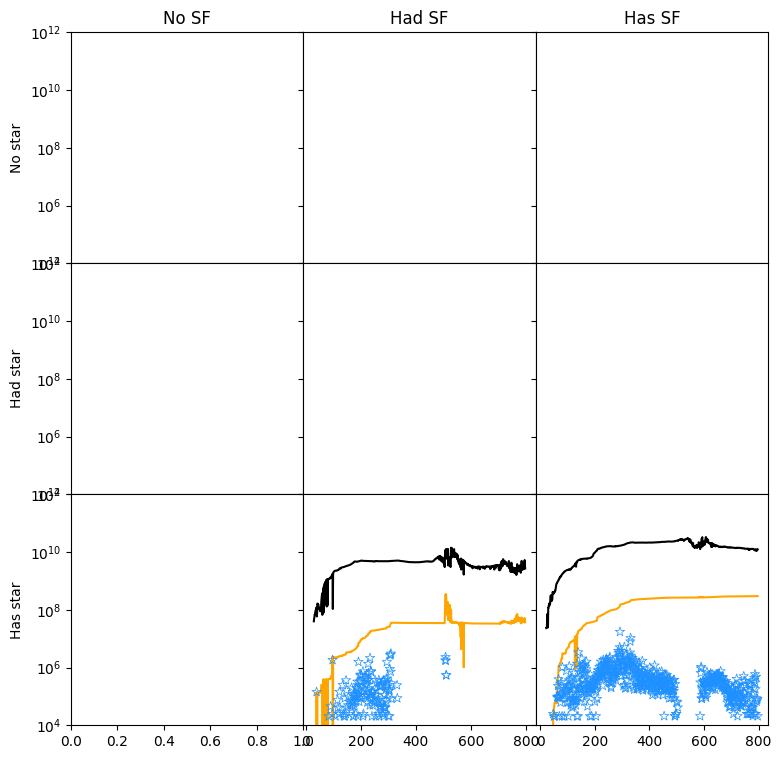

In [35]:
p1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for pair in pairs2:
    branch = stree2[pair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p1cases[0][1].append(pair['id'])
    else:
        if(pair['mstar_vir']==0):
            p1cases[1][1].append(pair['id'])
        else:
            p1cases[2][1].append(pair['id'])
for case in p1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(pairs2)*100:.2f}%")

p2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for pair in pairs2:
    branch = stree2[pair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p2cases[0][1].append(pair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            p2cases[1][1].append(pair['id'])
        else:
            p2cases[2][1].append(pair['id'])
for case in p2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(pairs2)*100:.2f}%")

p1a = p1cases[0][1]; p1b = p1cases[1][1]; p1c = p1cases[2][1]
p2a = p2cases[0][1]; p2b = p2cases[1][1]; p2c = p2cases[2][1]
pcases = []
print('No star')
ids = np.array(p1a)[isin(p1a,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['No star',"No SF", ids])
ids = np.array(p1a)[isin(p1a,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['No star',"Had SF", ids])
ids = np.array(p1a)[isin(p1a,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(p1b)[isin(p1b,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['Had star',"No SF", ids])
ids = np.array(p1b)[isin(p1b,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['Had star',"Had SF", ids])
ids = np.array(p1b)[isin(p1b,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(p1c)[isin(p1c,p2a)]; print(f"    No SF {len(ids)}"); pcases.append(['Has star',"No SF", ids])
ids = np.array(p1c)[isin(p1c,p2b)]; print(f"    had SF {len(ids)}"); pcases.append(['Has star',"Had SF", ids])
ids = np.array(p1c)[isin(p1c,p2c)]; print(f"    has SF {len(ids)}"); pcases.append(['Has star',"Has SF", ids])
casedict['NH2']['p'] = pcases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(pcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree2[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.5)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show(); plt.close()

### How to do?
- (Has star No SF): Just by recent merging? or interloper?: **See when it has stars**
- (Has star Had SF): Normal but why quenched? : **see quenching start**
- (Has star Has SF): Normal: **just full movie**

## Upair

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 61 100.00%
no SF forever 37 60.66%
had SF, but not now 23 37.70%
has SF 1 1.64%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 37
    had SF 23
    has SF 1


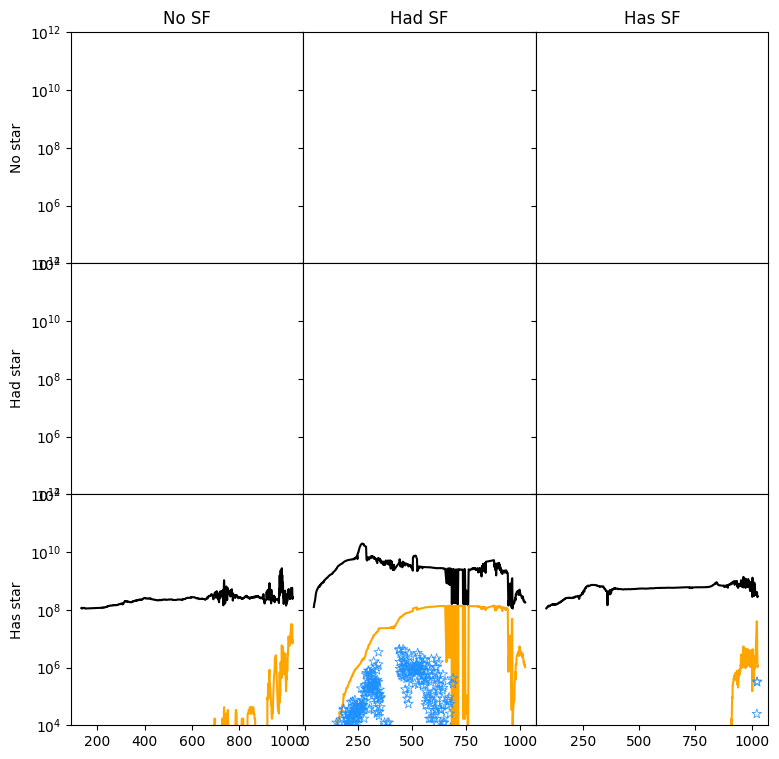

In [36]:
u1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for upair in upairs1:
    branch = stree1[upair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u1cases[0][1].append(upair['id'])
    else:
        if(upair['mstar_vir']==0):
            u1cases[1][1].append(upair['id'])
        else:
            u1cases[2][1].append(upair['id'])
for case in u1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(upairs1)*100:.2f}%")

u2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for upair in upairs1:
    branch = stree1[upair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u2cases[0][1].append(upair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            u2cases[1][1].append(upair['id'])
        else:
            u2cases[2][1].append(upair['id'])
for case in u2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(upairs1)*100:.2f}%")

u1a = u1cases[0][1]; u1b = u1cases[1][1]; u1c = u1cases[2][1]
u2a = u2cases[0][1]; u2b = u2cases[1][1]; u2c = u2cases[2][1]
ucases = []
print('No star')
ids = np.array(u1a)[isin(u1a,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['No star',"No SF", ids])
ids = np.array(u1a)[isin(u1a,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['No star',"Had SF", ids])
ids = np.array(u1a)[isin(u1a,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(u1b)[isin(u1b,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['Had star',"No SF", ids])
ids = np.array(u1b)[isin(u1b,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['Had star',"Had SF", ids])
ids = np.array(u1b)[isin(u1b,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(u1c)[isin(u1c,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['Has star',"No SF", ids])
ids = np.array(u1c)[isin(u1c,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['Has star',"Had SF", ids])
ids = np.array(u1c)[isin(u1c,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['Has star',"Has SF", ids])
casedict['NH']['u'] = ucases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(ucases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.5)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show(); plt.close()

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 43 100.00%
no SF forever 17 39.53%
had SF, but not now 25 58.14%
has SF 1 2.33%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 17
    had SF 25
    has SF 1


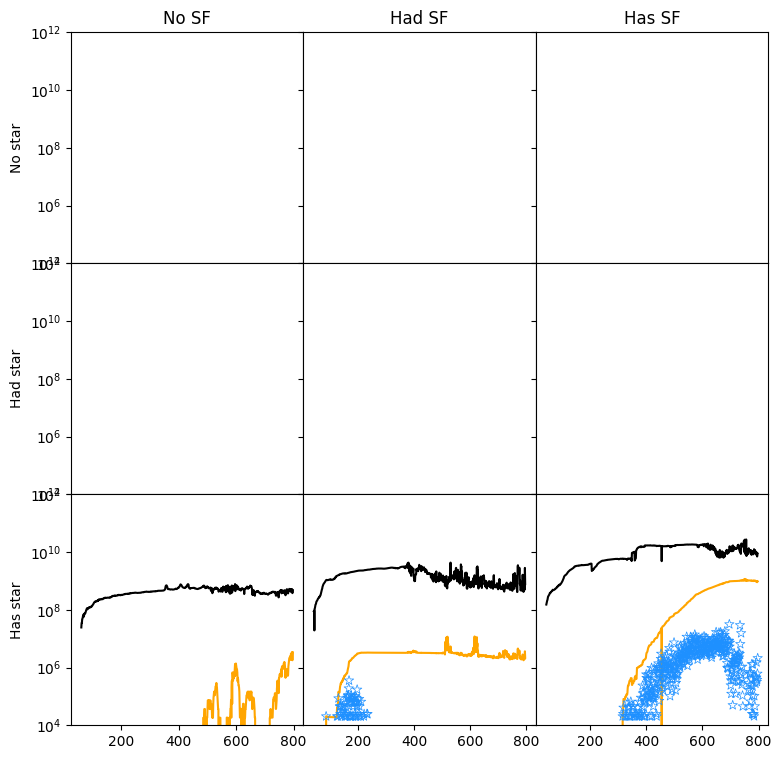

In [37]:
u1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for upair in upairs2:
    branch = stree2[upair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u1cases[0][1].append(upair['id'])
    else:
        if(upair['mstar_vir']==0):
            u1cases[1][1].append(upair['id'])
        else:
            u1cases[2][1].append(upair['id'])
for case in u1cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(upairs2)*100:.2f}%")

u2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for upair in upairs2:
    branch = stree2[upair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u2cases[0][1].append(upair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0):
            u2cases[1][1].append(upair['id'])
        else:
            u2cases[2][1].append(upair['id'])
for case in u2cases:
    print(case[0], len(case[1]), f"{len(case[1])/len(upairs2)*100:.2f}%")

u1a = u1cases[0][1]; u1b = u1cases[1][1]; u1c = u1cases[2][1]
u2a = u2cases[0][1]; u2b = u2cases[1][1]; u2c = u2cases[2][1]
ucases = []
print('No star')
ids = np.array(u1a)[isin(u1a,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['No star',"No SF", ids])
ids = np.array(u1a)[isin(u1a,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['No star',"Had SF", ids])
ids = np.array(u1a)[isin(u1a,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(u1b)[isin(u1b,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['Had star',"No SF", ids])
ids = np.array(u1b)[isin(u1b,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['Had star',"Had SF", ids])
ids = np.array(u1b)[isin(u1b,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(u1c)[isin(u1c,u2a)]; print(f"    No SF {len(ids)}"); ucases.append(['Has star',"No SF", ids])
ids = np.array(u1c)[isin(u1c,u2b)]; print(f"    had SF {len(ids)}"); ucases.append(['Has star',"Had SF", ids])
ids = np.array(u1c)[isin(u1c,u2c)]; print(f"    has SF {len(ids)}"); ucases.append(['Has star',"Has SF", ids])
casedict['NH2']['u'] = ucases

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(ucases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree2[iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.5)
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show(); plt.close()

### How to do?
- (Has star No SF): Just by recent merging? or interloper?: **See when it has stars**
- (Has star Had SF): Normal but why quenched? : **see quenching start**

In [39]:
pklsave(casedict['NH'], f"{database1}/case_dict.pickle")
pklsave(casedict['NH2'], f"{database2}/case_dict.pickle")